# Рекуррентные нейронные сети

# Векторизация слов

In [1]:
# N-граммы (комбинации из N последовательных терминов)
from sklearn.feature_extraction.text import CountVectorizer

print("Модель для N-грамм от 1 до 1 слова")  # bag of words
vect = CountVectorizer(ngram_range=(1, 1)) 
res = vect.fit_transform(['он не делает работу', 'не он делает работу']).toarray()
print(res)
print(vect.vocabulary_)

print()
print("Модель для N-грамм от 1 до 2 слов")
vect = CountVectorizer(ngram_range=(1, 2)) 
res = vect.fit_transform(['он не делает работу', 'не он делает работу']).toarray()
print(res)
print(vect.vocabulary_)

Модель для N-грамм от 1 до 1 слова
[[1 1 1 1]
 [1 1 1 1]]
{'он': 2, 'не': 1, 'делает': 0, 'работу': 3}

Модель для N-грамм от 1 до 2 слов
[[1 1 1 1 0 1 0 1 1]
 [1 1 1 0 1 1 1 0 1]]
{'он': 5, 'не': 2, 'делает': 0, 'работу': 8, 'он не': 7, 'не делает': 3, 'делает работу': 1, 'не он': 4, 'он делает': 6}


### Word2Vec
<img src="images/LessonsI/embeddings_structure.png" alt="w2v" height=50% width=50%>

In [2]:
import codecs
import numpy as np
import gensim

In [18]:
# with codecs.open('data/LOTR.txt', encoding='utf-8', mode='r') as f:
with codecs.open('./data/filtered.txt', encoding='utf-8', mode='r') as f:    
    text = f.readlines()
    
max_sentence_len = 12

sentences = [sent for doc in text for sent in doc.split('.')]
sentences = [[word for word in sent.lower().split()[:max_sentence_len]] for sent in sentences]
sentences

[['в',
  'начале',
  'июля',
  'в',
  'чрезвычайно',
  'жаркое',
  'время',
  'под',
  'вечер',
  'один',
  'молодой',
  'человек'],
 [],
 ['он',
  'благополучно',
  'избегнул',
  'встречи',
  'с',
  'своею',
  'хозяйкой',
  'на',
  'лестнице'],
 ['каморка',
  'его',
  'приходилась',
  'под',
  'самою',
  'кровлей',
  'высокого',
  'пятиэтажного',
  'дома',
  'и',
  'походила',
  'более'],
 ['квартирная',
  'же',
  'хозяйка',
  'его',
  'у',
  'которой',
  'он',
  'нанимал',
  'эту',
  'каморку',
  'с',
  'обедом'],
 ['и',
  'каждый',
  'раз',
  'молодой',
  'человек',
  'проходя',
  'мимо',
  'чувствовал',
  'какоето',
  'болезненное',
  'и',
  'трусливое'],
 ['он',
  'был',
  'должен',
  'кругом',
  'хозяйке',
  'и',
  'боялся',
  'с',
  'нею',
  'встретиться'],
 [],
 ['не',
  'то',
  'чтоб',
  'он',
  'был',
  'так',
  'труслив',
  'и',
  'забит',
  'совсем',
  'даже',
  'напротив'],
 ['он',
  'до',
  'того',
  'углубился',
  'в',
  'себя',
  'и',
  'уединился',
  'от',
  'всех',
  

In [6]:
# Обучение модели
word_model = gensim.models.Word2Vec(sentences, vector_size=100, min_count=1, window=5, epochs=100)

In [10]:
pretrained_weights = word_model.wv.vectors
vocab_size, embedding_size = pretrained_weights.shape
print(vocab_size, embedding_size)

21571 100


In [23]:
print('Похожие слова:')
for word in ['хоббит', 'кольцо', 'гном', 'эльф', 'лук', 'пин']:
    most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in word_model.wv.most_similar(word)[:8])
    print('  %s -> %s' % (word, most_similar))


Похожие слова:
  хоббит -> приземистый (0.69), глупый (0.66), престарелый (0.64), румяным (0.64), длинноноги! (0.64), щеками, (0.61), завопил (0.60), колдун (0.60)
  кольцо -> оно (0.56), кольцо, (0.54), проклятье (0.50), таким, (0.47), сердце (0.46), найдено (0.46), келебримбор, (0.45), желание (0.44)
  гном -> встречей! (0.61), добрым (0.59), вперед! (0.57), голосом (0.57), голосом: (0.57), стойте (0.57), плечами (0.57), ура! (0.56)
  эльф -> свистящим (0.70), фермер, (0.68), эй! (0.66), собирая (0.65), леголас (0.64), голосом: (0.64), арагорн! (0.64), смеагорл, (0.64)
  лук -> колчан (0.65), одноэтажным, (0.65), светится (0.64), напитка (0.63), трон, (0.63), выточен (0.63), медовый (0.63), сырым, (0.63)
  пин -> мерри (0.70), бродяжник (0.62), сэм (0.60), пиппин (0.60), мерри, (0.59), леголас (0.55), пиппин, (0.55), халдир (0.55)


In [13]:
# Получение вектора
word_model.wv.get_vector('хоббит')

array([-0.5275733 , -0.49038413,  0.26530552, -0.55259633,  0.58883405,
       -0.5094188 ,  1.6025951 ,  1.8401952 , -1.0579935 ,  0.84028965,
        0.5595202 , -0.32262352, -0.32784835, -0.08210766, -0.33168343,
       -1.0980718 , -0.2449308 , -1.1738994 , -0.3005365 , -1.3311998 ,
        0.4990352 , -0.16485004, -0.23623984, -0.8880814 , -0.02566478,
       -0.9168636 ,  1.0509665 , -0.21874544, -0.35874528, -1.0377768 ,
       -0.04610081,  0.0591987 ,  0.41245377, -0.10338879,  0.18250333,
       -0.5635397 ,  0.41803986, -0.82597816,  0.17581068, -0.5880946 ,
       -0.16376743,  0.16672383, -0.70335317, -0.20451789,  0.5165798 ,
        0.5015588 ,  0.62059087,  0.7163039 ,  0.8874517 , -0.14966896,
       -0.4986672 , -0.9387815 ,  0.5809278 , -0.42801148, -0.41819337,
        0.66595894,  0.5018071 ,  0.54891986, -0.14095579,  0.8053368 ,
        1.332187  , -0.46000987,  2.1419404 , -0.86157966,  0.03455767,
        0.5401899 , -0.15926014,  0.24465467, -0.7497663 ,  0.07

In [22]:
vec = word_model.wv.get_vector('пони') - word_model.wv.get_vector('хоббит') + word_model.wv.get_vector('маг')
word_model.wv.similar_by_vector(vec)

[('пони', 0.8067206144332886),
 ('мерри', 0.5627685189247131),
 ('беспокойно', 0.49933090806007385),
 ('маг', 0.4963756501674652),
 ('пин', 0.48173031210899353),
 ('том', 0.4802573025226593),
 ('бродяжник', 0.4759186804294586),
 ('кухню', 0.4708172082901001),
 ('подъем', 0.4629760682582855),
 ('прямо', 0.46119844913482666)]

# RNN
Рекуррентные нейронные сети (RNN) — вид нейронных сетей, где связи между элементами образуют направленную последовательность. Благодаря этому появляется возможность обрабатывать серии событий во времени или последовательные пространственные цепочки. В отличие от многослойных перцептронов, рекуррентные сети могут использовать свою внутреннюю память для обработки последовательностей произвольной длины. Поэтому сети RNN применимы в таких задачах, где нечто целостное разбито на части, например: распознавание рукописного текста или распознавание речи. 
<img src="https://habrastorage.org/web/5c8/0fa/c22/5c80fac224d449209d888d18ea1111a8.png" alt="RNN">

## Внутреннее устройство простых RNN
Входной вектор и вектор внутренней памяти объединяются и отправляются на полносвязный слой с функцией активации *tanh*
<img src="https://habrastorage.org/web/47d/ee6/2c3/47dee62c3af8498c946befa1f3330d90.png"  alt="RNN In"  height=70% width=70%>

$$h_t = tanh(w * [h_{t-1}; x_t])$$

## Виды RNN
<img src="images/rnn/rnns.jpg"  alt="RNN In"  height=70% width=70%>

### Many to many (Генерация текста)
<img src="images/rnn/rnn_m2m.jpeg"  alt="RNN In"  height=50% width=50%>

### One to many (Подпись изображений)
<img src="images/rnn/rnn_o2m.png"  alt="RNN In"  height=70% width=70%>
Началом и концом предложения являются специальные слова: $<start>$ $<end>$

# LSTM
Долгая краткосрочная память (Long short-term memory; LSTM) – особая разновидность архитектуры рекуррентных нейронных сетей, способная к обучению долговременным зависимостям.
<img src="https://habrastorage.org/web/67b/04f/73b/67b04f73b4c34ba38edfa207e09de07c.png" alt="LSTM">
* «вентиль забывания» контролирует меру сохранения значения в памяти
* «входной вентиль» контролирует меру вхождения нового значения в память
* «выходной вентиль» контролирует меру того, в какой степени значение, находящееся в памяти, используется при расчёте выходной функции активации для блока

### «Вентиль забывания»
<img src="https://habrastorage.org/web/a5f/31a/104/a5f31a104b184217aca105de9ab6d320.png">

### «Входной вентиль»
<img src="https://habrastorage.org/web/248/bf4/a75/248bf4a75ab74bf180b9c0e2e2cc5a58.png">

### «Выходной вентиль»
<img src="https://habrastorage.org/web/16d/5b5/783/16d5b5783ba34244afcf0f240133fb28.png">

# GRU
Управляемые рекуррентные блоки (Gated Recurrent Units, GRU) — механизм вентилей для рекуррентных нейронных сетей, представленный в 2014 году. Было установлено, что его эффективность при решении задач моделирования музыкальных и речевых сигналов сопоставима с использованием долгой краткосрочной памяти (LSTM). По сравнению с LSTM у данного механизма меньше параметров, т.к. отсутствует выходной вентиль.
<img src="https://www.data-blogger.com/wp-content/uploads/2017/08/gru.png" alt="GRU">

# Архитектуры LSTM
### Объединение нескольких RNN
<img src="images/rnn/rnn_arch.png"  height=50% width=50%>

### Двунаправленные
<img src="images/rnn/rnn_bi.jpg"  height=70% width=70%>

### Seq2Seq
<img src="images/rnn/seq2seq.png"  height=70% width=70%>

### Архитектура Google’s Neural Machine Translation
<img src="images/rnn/rnn_ggle.png"  height=100% width=100%>

# Механизм внимания (Attention)
<img src="images/rnn/rnn_att.png"  height=30% width=30%>


<img src="images/rnn/att1.jpeg"  height=90% width=90%>
<img src="images/rnn/att2.jpeg"  height=90% width=90%>

### Результат
<img src="images/rnn/map_att.png"  height=70% width=70%>

# Пример

In [76]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


df = pd.read_csv('./data/production.csv')
df.head()

,API,Year,Month,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate
0,5005072170100,2014,11,9783,11470,1.172442,10558,1.079219,14,2016-04-06 17:20:05.757
1,5005072170100,2014,12,24206,26476,1.093778,5719,0.236264,31,2016-04-06 17:20:05.757
2,5005072170100,2015,1,20449,26381,1.290088,2196,0.107389,31,2016-04-06 17:20:05.757
3,5005072170100,2015,2,6820,10390,1.523460,583,0.085484,28,2016-04-06 17:20:05.757
4,5005072170100,2015,3,7349,7005,0.953191,122,0.016601,13,2016-06-16 14:07:33.203


In [26]:
# Подготовка данных по добыче
liquid = df.groupby('API')['Liquid'].apply(lambda df_: df_.reset_index(drop=True))
liquid.head()

API             
5005072170100  0     9783
               1    24206
               2    20449
               3     6820
               4     7349
Name: Liquid, dtype: int64

In [27]:
df_prod = liquid.unstack()
df_prod.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
API,,,,,,,,,,,,,,,,,,,,,
5005072170100,9783,24206,20449,6820,7349,16552,13844,10655,6135,11105,...,6547,5117,5280,4762,4962,4478,4328,4777,3849,3835
5123377130000,2341,4689,3056,1979,2037,2260,1961,1549,1364,1380,...,898,787,880,879,773,737,543,732,559,633
5123379280000,6326,6405,6839,6584,4775,3917,3840,3031,3137,2669,...,1795,1852,1734,1588,1739,1473,1472,1378,1235,1331
5123379400000,8644,13977,9325,6445,5326,4538,3403,2534,2685,2597,...,1537,1331,1305,1510,1476,1729,1606,1388,1632,814
5123385820100,1753,4402,1187,1204,1176,1523,1169,782,634,597,...,60,0,0,0,0,0,236,830,6,571


In [28]:
# Масштабирование и деление на трейн/тест
data = df_prod.values
data = data / data.max()
data = data[:, :, np.newaxis]

data_tr = data[:40]
data_tst = data[40:]
print(data_tr.shape, data_tst.shape)

(40, 24, 1) (10, 24, 1)


In [29]:
x_data = [data_tr[:, i:i+12] for i in range(11)]
y_data = [data_tr[:, i+1:i+13] for i in range(11)]

x_data = np.concatenate(x_data, axis=0)
y_data = np.concatenate(y_data, axis=0)
print(x_data.shape, y_data.shape)

(440, 12, 1) (440, 12, 1)


In [83]:
tensor_x = torch.Tensor(x_data) # transform to torch tensor
tensor_y = torch.Tensor(y_data)

oil_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
oil_dataloader = DataLoader(oil_dataset, batch_size=16) # create your dataloader

In [84]:
for x_t, y_t in oil_dataloader:
    break
x_t.shape, y_t.shape

(torch.Size([16, 12, 1]), torch.Size([16, 12, 1]))

In [130]:
class OilModel(nn.Module):
    def __init__(self, timesteps=12, units=32):
        super().__init__()
        self.lstm1 = nn.LSTM(1, units, 2, batch_first=True)
        self.dense = nn.Linear(units, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h, _ = self.lstm1(x)
        outs = []
        for i in range(h.shape[0]):
            outs.append(self.relu(self.dense(h[i])))
        out = torch.stack(outs, dim=0)
        return out

In [131]:
model = OilModel()
opt = optim.Adam(model.parameters())
criterion = nn.MSELoss()

In [133]:
NUM_EPOCHS = 20

for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    num = 0
    for x_t, y_t in oil_dataloader:
        # zero the parameter gradients
        opt.zero_grad()

        # forward + backward + optimize
        outputs = model(x_t)
        loss = criterion(outputs, y_t)
        loss.backward()
        opt.step()

        # print statistics
        running_loss += loss.item()
        num += 1
        
    print(f'[Epoch: {epoch + 1:2d}] loss: {running_loss / num:.3f}')

print('Finished Training')

[Epoch:  1] loss: 0.008
[Epoch:  2] loss: 0.009
[Epoch:  3] loss: 0.009
[Epoch:  4] loss: 0.008
[Epoch:  5] loss: 0.007
[Epoch:  6] loss: 0.006
[Epoch:  7] loss: 0.005
[Epoch:  8] loss: 0.005
[Epoch:  9] loss: 0.004
[Epoch: 10] loss: 0.004
[Epoch: 11] loss: 0.004
[Epoch: 12] loss: 0.004
[Epoch: 13] loss: 0.003
[Epoch: 14] loss: 0.003
[Epoch: 15] loss: 0.003
[Epoch: 16] loss: 0.003
[Epoch: 17] loss: 0.003
[Epoch: 18] loss: 0.003
[Epoch: 19] loss: 0.003
[Epoch: 20] loss: 0.003
Finished Training


In [135]:
# Предскажем на год вперёд используя данные только первого года
x_tst = data_tst[:, :12]
predicts = np.zeros((x_tst.shape[0], 0, x_tst.shape[2]))

for i in range(12):
    x = np.concatenate((x_tst[:, i:], predicts), axis=1)
    x_t = torch.from_numpy(x).float()
    pred = model(x_t).detach().numpy()
    last_pred = pred[:, -1:]  # Нас интересует только последний месяц
    predicts = np.concatenate((predicts, last_pred), axis=1)

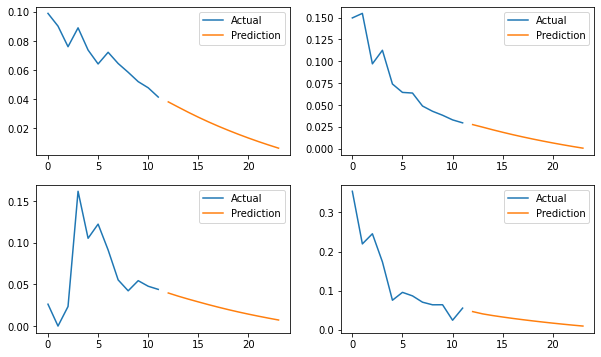

In [136]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for iapi in range(4):
    plt.subplot(2, 2, iapi+1)
    plt.plot(np.arange(x_tst.shape[1]), x_tst[iapi, :, 0], label='Actual')
    plt.plot(np.arange(predicts.shape[1])+x_tst.shape[1], predicts[iapi, :, 0], label='Prediction')
    plt.legend()
plt.show()

# Задание
1. Подготовьте данные для word2vec по одной из недавно прочитанных книг, удалив все символы, кроме букв и пробелов и обучите модель. Посмотрите результат.
2. Для обучения на нефтяных скважин добавьте во входные данные информацию со столбцов Gas, Water (т.е. размер x_data будет (440, 12, 3)) и обучите новую модель. Выход содержит Liquid, Gas и Water (для дальнейшего предсказания). Графики с результатами только для Liquid.
3. Из этого же текста (п.1) возьмите небольшой фрагмент, разбейте на предложения с одинаковым числом символов. Каждый символ предложения закодируйте с помощью one hot encoding. В итоге у вас должен получиться массив размера (n_sentences, sentence_len, encoding_size).
4. На полученных в п.3 задании обучение модель RNN для предсказания следующего символа. Посмотрите результат при последовательной генерации.
5. \* (не обязательное) На полученных в п.1 задании обучение модель RNN для предсказания следующего слова. Посмотрите результат при последовательной генерации.